# RL Problem Set 1

In [53]:
# Required Imports
import numpy as np
import matplotlib.pyplot as plt

# Basic Definitions and Utilities

In [54]:
# Basic properties of the MDP
N = 100  # Maximum length of the queue
A = 2  # Number of actions
gamma = 0.9  # Discount factor
p = 0.5  # Arrival rate of requests
q_low = 0.51  # Service rate for action alow
q_high = 0.6  # Service rate for action ahigh
c_low = 0  # Cost for action alow
c_high = 0.01  # Cost for action ahigh

# Reward function based on state x and action a
def reward(x, a):
    if a == 'alow':
        return -(x/N)**2
    elif a == 'ahigh':
        return -(x/N)**2 - c_high

# Truncate function to keep queue length within bounds
def trunc(x):
    return min(N-1, max(x, 0))

## Problem 1: *Policy Evaluation*

### 1.1 Defining the two policies

In [55]:
# pi_lazy: always chooses the 'alow' action
pi_lazy = np.zeros((N, A))
pi_lazy[:, 0] = 1  # Always choose action alow 

# pi_aggressive: chooses 'alow' action for state less than 50 and 'ahigh' for states 50 and above
pi_aggressive = np.zeros((N, A))
pi_aggressive[:50, 0] = 1  # Choose action alow for x < 50
pi_aggressive[50:, 1] = 1  # Choose action ahigh for x >= 50

### 1.2 Transition Probabilities

In [56]:
# trans_prob: transition probability from state x to x' given action a
def trans_prob(x, a):
    transition_probs = np.zeros(N)
    
    # Set the increment and decrement probabilities based on the action
    increment_probs = [1-p, p]
    if a == 0:  # alow
        decrement_probs = [1-q_low, q_low]
    else:  # ahigh
        decrement_probs = [1-q_high, q_high]
    
    # Compute the transition probabilities for all possible increments and decrements
    for increment in [0, 1]:
        for decrement in [0, 1]:
            new_x = trunc(x + increment - decrement)
            transition_probs[new_x] += increment_probs[increment] * decrement_probs[decrement]
    return transition_probs

# trans: transition probability matrix for the given policy
def trans(pi):
    P_pi = np.zeros((N, N))
    
    # Compute the transition probability matrix for the given policy
    for x in range(N):
        for x_prime in range(N):
            P_pi[x, x_prime] = sum(pi[x, a] * trans_prob(x, a)[x_prime] for a in range(A))
    return P_pi

### 1.3 Evaluation Procedure

In [57]:
# Evaluation method of the policy using the Bellman equations.
# The value function V^π is derived by directly solving V^π = r^π + γP^πV^π
def evaluate(pi):
    r_pi = np.array([reward(x, 'alow' if pi[x, 0] == 1 else 'ahigh') for x in range(N)])
    P_pi = trans(pi)
    I = np.eye(N)
    value = np.linalg.solve(I - gamma * P_pi, r_pi)
    return value

In [58]:
# Evaluate the given policies
value_lazy = evaluate(pi_lazy)
value_aggressive = evaluate(pi_aggressive)

### 1.4 Plotting the Value Function

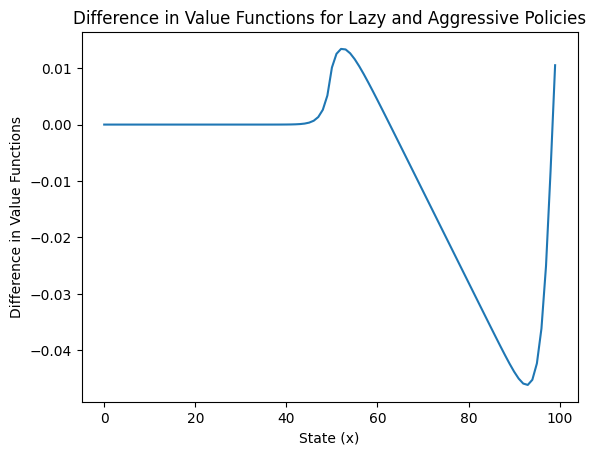

In [59]:
# Plotting the value functions for the two policies
# If difference is positive, then the lazy policy is better
# If difference is negative, then the aggressive policy is better
# If difference is zero, then both policies are equally good

difference = value_lazy - value_aggressive
plt.plot(range(N), difference)
plt.xlabel("State (x)")
plt.ylabel("Difference in Value Functions")
plt.title("Difference in Value Functions for Lazy and Aggressive Policies")
plt.show()

### Summary of Observations from the Value Function Differences Plot:

1. **Significance of Differences**:
   - <u>Positive differences</u> indicate that the **lazy policy is superior** in terms of expected cumulative reward for that state.
   - <u>Negative differences</u> suggest the **aggressive policy is superior**.

2. **Shorter Queues (x < 50)**:
   - Initially the lazy policy is marginally better or nearly equivalent to the aggressive policy.

3. **Around Queue Length of 50**:
   - There's a notable shift in the trend post x=50, suggesting the lazy policy is slightly more effective when the queue length is close to 50 and then aggressive policy becomes more effective as the queue length surpasses 50.

4. **Longer Queues (50 ≤ x < 80)**:
   - The aggressive policy continues to be superior as indicated by the increasingly negative difference.

5. **End of Queue (near x=100)**:
   - A sharp positive spike suggests the lazy policy might be more beneficial due to boundary effects (trunc method). 
   - The aggressive policy's higher cost might not be beneficial here, especially when the queue can't grow beyond the truncation point.

In [61]:
print(f"Value at state 50 for Lazy Policy: {value_lazy[50]} and for Aggressive Policy: {value_aggressive[50]}")
print(f"Value at state 80 for Lazy Policy: {value_lazy[80]} and for Aggressive Policy: {value_aggressive[80]}")

Value at state 50 for Lazy Policy: -2.495516199999999 and for Aggressive Policy: -2.505626101063741
Value at state 80 for Lazy Policy: -6.39011564760478 and for Aggressive Policy: -6.362119989336483


### Observations for Specific States:

- **State 50**:
  - Lazy Policy Value: -2.4955
  - Aggressive Policy Value: -2.5056
  - **Better Policy**: Lazy (since its value is slightly higher).

- **State 80**:
  - Lazy Policy Value: -6.3901
  - Aggressive Policy Value: -6.3621
  - **Better Policy**: Aggressive (as it has a higher value).


## PROBLEM 2: *Value Iteration and Policy Iteration*

In [62]:
# Additional Required Imports
import time

### 2.1 Reward matrix

In [63]:
# Reward matrix for each state and action
r = np.zeros((N, A))
for x in range(N):
    r[x, 0] = reward(x, 'alow')
    r[x, 1] = reward(x, 'ahigh')

### 2.2 Transition probability matrix

In [64]:
# Transition probability matrix:
# P[x, x', a] = P(x'|x, a) -> Probability of transitioning from state x to state x' given action a
P = np.zeros((N, N, A)) 
for x in range(N):
    for a in range(A):
        P[x, :, a] = trans_prob(x, a)

### 2.3 Value Iteration

In [65]:
# Value Iteration
def value_iteration(P, r, gamma, V, max_iter):
    X = np.size(P, 0)
    iterations_to_store = [10, 20, 50, 100] # Iterations to store the value function for
    stored_values = {} # Dictionary to store the value function for the given iterations
    
    # Run the value iteration algorithm for the given number of iterations
    for k in range(max_iter):
        V_new = np.copy(V)
        # Update the value function for each state
        for x in range(X):
            q_values = np.array([r[x, a] + gamma * np.dot(P[x, :, a], V) for a in range(A)])
            V_new[x] = np.max(q_values)
        
        V = V_new
        if k+1 in iterations_to_store:
            stored_values[k+1] = np.copy(V)
    
    # Extract the optimal policy based on the converged value function
    opt_policy_VI = np.argmax(np.array([r[:, a] + gamma * np.dot(P[:, :, a], V) for a in range(A)]), axis=0)
    
    return V, stored_values, opt_policy_VI


### 2.4 Policy Iteration

In [66]:
# Policy Iteration
def policy_iteration(P, r, gamma, V, max_iter):
    X = np.size(P, 0)
    A = np.size(P, 2)
    iterations_to_store = [10, 20, 50, 100] # Iterations to store the value function for
    stored_values = {} # Dictionary to store the value function for the given iterations
    
    # Run the policy iteration algorithm for the given number of iterations
    for k in range(max_iter):
        # Policy Improvement
        pi = np.zeros((X, A))
        # Update the policy for each state
        for x in range(X):
            q_values = np.array([r[x, a] + gamma * np.dot(P[x, :, a], V) for a in range(A)])
            best_action = np.argmax(q_values)
            pi[x] = np.zeros(A)
            pi[x, best_action] = 1
        
        # Policy Evaluation (using the Bellman equations)
        V = evaluate(pi)
        
        if k+1 in iterations_to_store:
            stored_values[k+1] = np.copy(V)
    
    # Extract the optimal policy based on the converged value function
    pi_opt = np.zeros((X, A))
    for x in range(X):
        q_values = np.array([r[x, a] + gamma * np.dot(P[x, :, a], V) for a in range(A)])
        best_action = np.argmax(q_values)
        pi_opt[x] = np.zeros(A)
        pi_opt[x, best_action] = 1
    
    return V, stored_values, pi_opt

### 2.5 Comparing Value Iteration and Policy Iteration

In [68]:
# Run Value Iteration
start_time = time.time()
opt_value_VI, stored_values_VI, opt_policy_VI = value_iteration(P, r, gamma, np.zeros(N), 100)
VI_time = time.time() - start_time

# Run Policy Iteration
start_time = time.time()
opt_value_PI, stored_values_PI, opt_policy_PI = policy_iteration(P, r, gamma, np.zeros(N), 100)
PI_time = time.time() - start_time

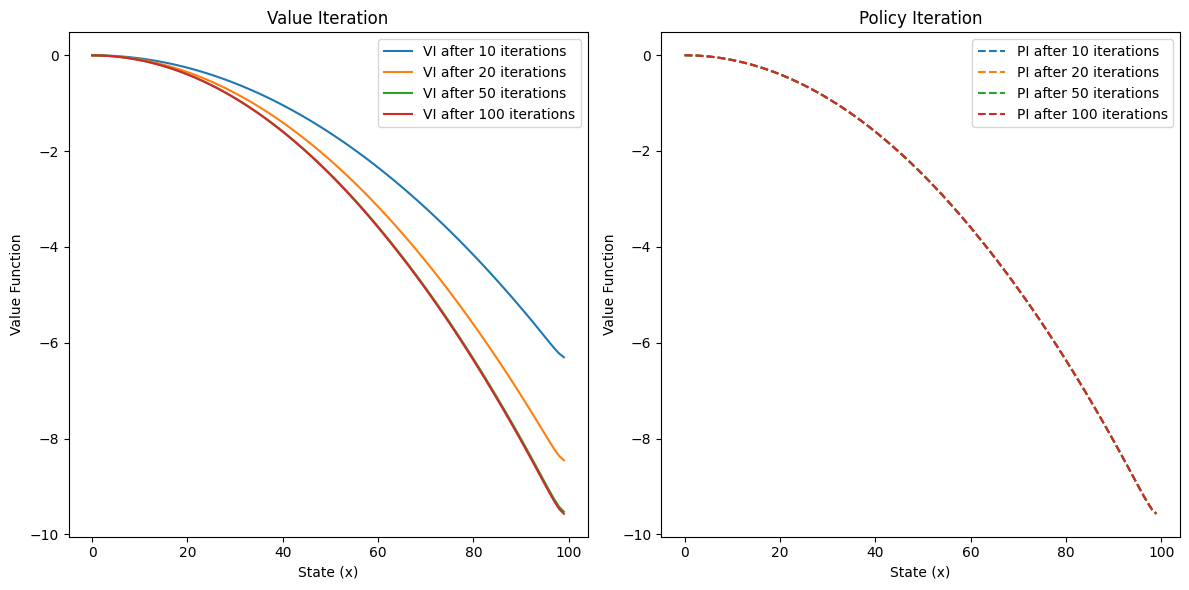

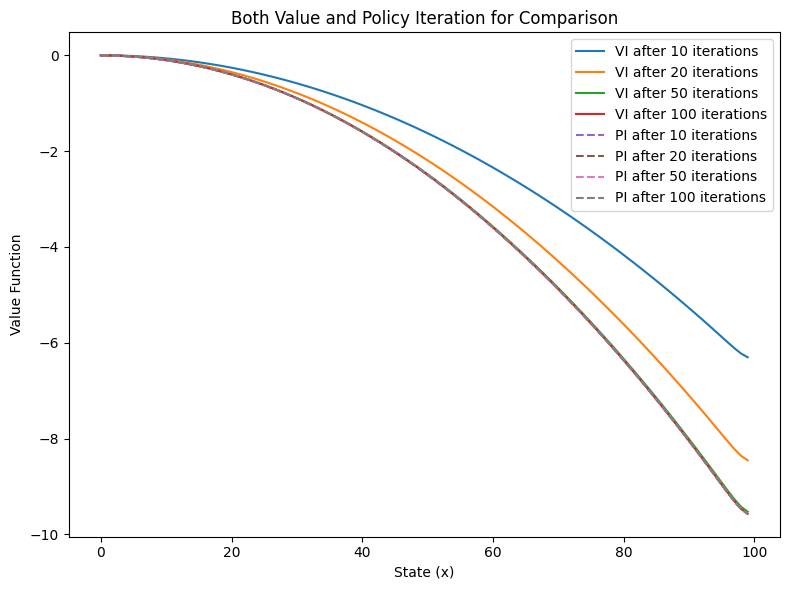

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the stored values for Value Iteration on ax1
for iter_count, value in stored_values_VI.items():
    ax1.plot(range(N), value, label=f"VI after {iter_count} iterations")
ax1.set_title("Value Iteration")
ax1.set_xlabel("State (x)")
ax1.set_ylabel("Value Function")
ax1.legend()

# Plotting the stored values for Policy Iteration on ax2
for iter_count, value in stored_values_PI.items():
    ax2.plot(range(N), value, linestyle='--', label=f"PI after {iter_count} iterations")
ax2.set_title("Policy Iteration")
ax2.set_xlabel("State (x)")
ax2.set_ylabel("Value Function")
ax2.legend()

plt.tight_layout()
plt.show()

# Plotting the combined values for both Value Iteration and Policy Iteration
plt.figure(figsize=(8, 6))
for iter_count, value in stored_values_VI.items():
    plt.plot(range(N), value, label=f"VI after {iter_count} iterations")
for iter_count, value in stored_values_PI.items():
    plt.plot(range(N), value, linestyle='--', label=f"PI after {iter_count} iterations")

plt.title("Both Value and Policy Iteration for Comparison")
plt.xlabel("State (x)")
plt.ylabel("Value Function")
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
# Print times for both methods
print(f"Time for Value Iteration: {VI_time:.4f} seconds")
print(f"Time for Policy Iteration: {PI_time:.4f} seconds")

Time for Value Iteration: 0.0795 seconds
Time for Policy Iteration: 8.2863 seconds


### Analysis of Value Iteration vs. Policy Iteration

#### <u>Observations</u>:
- **Value Functions Over Iterations**:
    - Both Value Iteration (VI) and Policy Iteration (PI) converge towards an optimal value function.
    - As seen in the plots, the value functions for both methods seem to stabilize after a certain number of iterations, indicating that they have likely converged to the optimal solution.

- **Convergence Rate**:
    - *Value Iteration*:
        - The value functions after 10, 20, 50, and 100 iterations gradually approach the optimal value function. 
        - The difference between consecutive iterations diminishes, indicating that the value function is stabilizing.
    - *Policy Iteration*:
        - The policy iteration method, after 10 iterations,seems to almost overlap with its value function after 100 iterations.
- **Convergence Speed**:
    - In terms of the number of iterations, Policy Iteration appears to converge faster to the optimal value function.
- **Runtimes**:
    - The time taken for 100 iterations with Value Iteration is 0.0795 seconds. 
    - This is significantly faster than Policy Iteration which takes 8.2863 seconds for 100 iterations.

#### <u>Interpretations</u>:
- **Convergence Insights**:
    - Both VI and PI aim to find the optimal value function, but their paths and rates of convergence differ.
    - While VI shows a steady approach towards the optimal value function across iterations, PI converges faster in its initial stages. This suggests that PI might be making more substantial policy updates early on, leading to fast convergence.
- **Computational Efficiency**:
    - Despite PI's faster convergence in terms of iterations, its computational cost is higher. This is evidenced by the runtime of 8.2863 seconds for 100 iterations, which is substantially more than VI's 0.0795 seconds.
    - This suggests that each iteration in PI, although it might be more effective in updating the policy, is also computationally more intensive.
- **Choosing Between VI and PI**:
    - If convergence speed (in terms of iterations) is a priority then PI might be the preferred choice for this case
    - However, if the focus is on computational efficiency and quicker runtimes, VI would be more suitable.

### 2.6 Plotting the Difference between Optimal and Basic Policy Value Functions

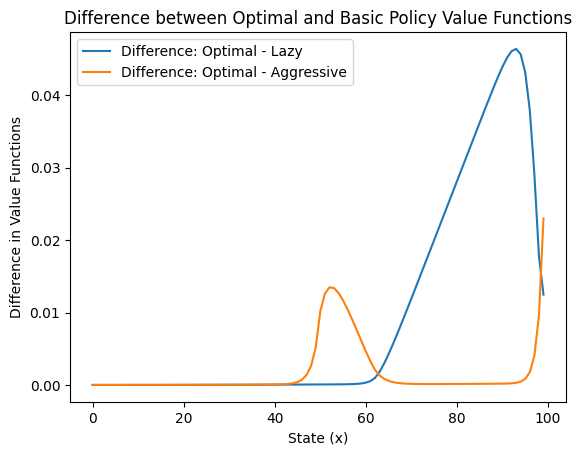

In [48]:
# Differences
diff_lazy_opt = opt_value_VI - value_lazy
diff_aggressive_opt = opt_value_VI - value_aggressive

plt.plot(range(N), diff_lazy_opt, label="Difference: Optimal - Lazy")
plt.plot(range(N), diff_aggressive_opt, label="Difference: Optimal - Aggressive")
plt.legend()
plt.xlabel("State (x)")
plt.ylabel("Difference in Value Functions")
plt.title("Difference between Optimal and Basic Policy Value Functions")
plt.show()

In [51]:
# Is the optimal value function strictly better than the value function of the lazy policy and the aggressive policy?

# 1. Check if any value is equal to zero for Lazy policy
strictly_better_than_lazy = all(value > 0 for value in diff_lazy_opt)

# 2. Check if any value is equal to zero for Aggressive policy
strictly_better_than_aggressive = all(value > 0 for value in diff_aggressive_opt)

# Print results
if strictly_better_than_lazy:
    print("The optimal value function V* strictly improves over the value function of the Lazy policy.")
else:
    print("The optimal value function V* does not strictly improve over the value function of the Lazy policy.")

if strictly_better_than_aggressive:
    print("The optimal value function V* strictly improves over the value function of the Aggressive policy.")
else:
    print("The optimal value function V* does not strictly improve over the value function of the Aggressive policy.")


The optimal value function V* strictly improves over the value function of the Lazy policy.
The optimal value function V* strictly improves over the value function of the Aggressive policy.


### Difference between Optimal and Basic Policy Value Functions
#### <u>Observations</u>:
- **Difference: Optimal - Lazy (Blue Curve)**:
    - The difference starts off near zero for the initial states.
    - After some iterations, the difference increases significantly, and then dips a bit as it reaches the final states. This indicates that for most states, the optimal policy's value function is higher (better) than that of the lazy policy.
- **Difference: Optimal - Aggressive (Orange Curve)**:
    - The difference starts off slightly above zero for the initial states.
    - It increases a bit at the start, and then dips back to a value slightly above 0 until near the end and it increases significantly makign the difference larger than the one with the laze for the final iterations.
    
#### <u>Analysis</u>:
- **Strict Improvement**:
    - Both curves are above the zero line throughout the plot, which means the optimal value function (V*) strictly improves over both the lazy and aggressive value functions for all states.

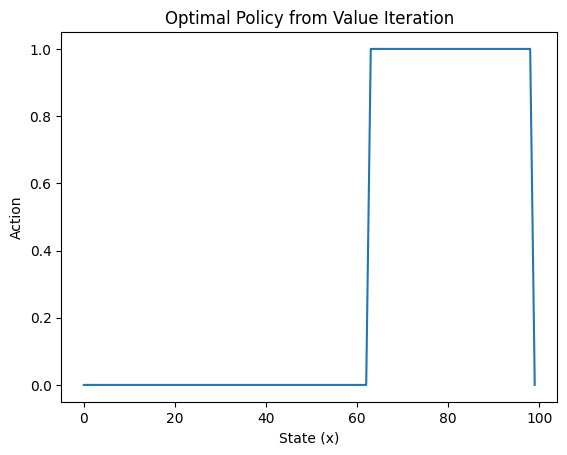

In [52]:
plt.plot(range(N), opt_policy_VI, label="Optimal Policy from VI")
plt.xlabel("State (x)")
plt.ylabel("Action")
plt.title("Optimal Policy from Value Iteration")
plt.show()


### Optimal Policy from Value Iteration analysis
#### <u>Observations:</u>
- **Action Value 0 ("alow" - low service rate)**:
    - For states ranging approximately from 0 to 60, the optimal policy suggests the action value 0.
- **Action Value 1 ("ahigh" - high service rate)**:
    - For states ranging approximately from 60 to near 100, the optimal policy suggests the action value 1.
- **Near 100**:
    - The optimal policy suggests action "alow", represented with 0, for the final states.

#### <u>Analysis:</u>
1. The optimal policy suggests that for the earlier states (approximately 0 to 60), "alow" (represented as 0) is most favorable. Having a lower service rate is more beneficial in these states.
2. For the later states (approximately 60 until near 100), the optimal action is favoring the action "ahigh" represented by 1. This suggests that having a higher service rate is more beneficial in these states.
3. Near 100 until the end, the optimal policy suggests action "alow" (represented by 0). This is likely due to the truncation method, which prevents the queue from growing beyond the maximum length of 100. In this case, having a lower service rate is more beneficial as the queue can't grow beyond 100.